In [1]:
%matplotlib notebook
%pylab
import matplotlib.pyplot as plt

Using matplotlib backend: nbAgg
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from photutils.psf.incremental_fit_photometry import *
from photutils import MMMBackground
import numpy as np
from astropy.table import Table
from thesis_lib.scopesim_helper import make_anisocado_model, make_gauss_model
from thesis_lib.testdata.generators import read_or_generate_image
from thesis_lib.scopesim_helper import download
from thesis_lib.testdata.recipes import scopesim_groups, gaussian_cluster

from scipy.spatial import ConvexHull, convex_hull_plot_2d
from matplotlib.patches import Polygon
from matplotlib.colors import LogNorm
from astropy.stats import sigma_clipped_stats
from thesis_lib.util import save_plot

In [3]:
## use these for interactive, disable for export
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10
plt.rcParams['figure.autolayout'] = True
from IPython.display import HTML
HTML('''
<style>
    .text_cell_render {
    font-size: 13pt;
    line-height: 135%;
    word-wrap: break-word;}
    
    .container { 
    min-width: 1200px;
    width:70% !important; 
    }}
</style>''')

In [14]:
model = make_anisocado_model()
#model = make_gauss_model(2)

In [5]:
def xy_scatter(result_table):
    plt.figure()
    result_table.sort('flux_fit', reverse=False)

    xdiff, ydiff = result_table['x_fit']-result_table['x_orig'], result_table['y_fit']-result_table['y_orig']
    xstd, xstd_clipped = np.std(xdiff),sigma_clipped_stats(xdiff, sigma=3)[2]
    ystd, ystd_clipped = np.std(ydiff),sigma_clipped_stats(ydiff, sigma=3)[2]

    plt.scatter(xdiff,ydiff,
                c=np.log(result_table['flux_fit']), cmap='plasma', s=20)
    plt.errorbar([0],[0],xerr=xstd,yerr=ystd, capsize=5, ls=':', color='tab:blue', label='std')
    plt.errorbar([0],[0],xerr=xstd_clipped,yerr=ystd_clipped, capsize=5, ls=':', color='tab:green', label='std clipped')
    plt.xlabel(f'{xstd=:.4f} {xstd_clipped=:.4f}')
    plt.ylabel(f'{ystd=:.4f} {ystd_clipped=:.4f}')

    plt.xlim(-1.5*xstd,1.5*xstd)
    plt.ylim(-1.5*xstd,1.5*xstd)

    plt.colorbar(label='log(flux)')
    plt.legend()
    

def image_and_sources(image, result_table):
    plt.figure()
    plt.imshow(image)
    plt.plot(result_table['x_0'], result_table['y_0'], 'kx', label='guess positions')
    plt.scatter(result_table['x_fit'], result_table['y_fit'], c=result_table['flux_fit'],
                cmap='Oranges_r', label='fitted positions')
    plt.legend()
    

def visualize_grouper(image, input_table, max_size=20, halo_radius=25):
    table = input_table.copy()
    
    table.rename_columns(['x','y'], ['x_fit', 'y_fit'])
    table['update'] = True
    groups = make_groups(table, max_size=max_size, halo_radius=halo_radius)

    group_ids = np.sort(np.unique([i for group in groups for i in group['group_id']]))
    max_id = np.max(group_ids)

    plt.figure()
    for group in groups:
        core_group = group[group['update']==True]
        group_id = core_group['group_id'][0]

        cmap = plt.get_cmap('prism')

        xy_curr = np.array((group['x_fit'], group['y_fit'])).T

        if len(group)>=3:
            hull = ConvexHull(xy_curr)
            vertices = xy_curr[hull.vertices]
            poly=Polygon(vertices, fill=False, color=cmap(group_id/max_id))
            plt.gca().add_patch(poly)

        plt.scatter(core_group['x_fit'], core_group['y_fit'], color=cmap(group_id/max_id), s=8)

        plt.annotate(group_id, (np.mean(core_group['x_fit']),np.mean(core_group['y_fit'])), 
                     color='white', backgroundcolor=(0,0,0,0.25), alpha=0.7)


    plt.imshow(image, norm=LogNorm())
    
def prepare_table(input_table):
    guess_table = input_table.copy()
    guess_table['x_orig'] = guess_table['x']
    guess_table['y_orig'] = guess_table['y']
    guess_table.rename_columns(['x', 'y', 'f'], [xguessname, yguessname, fluxguessname])
    guess_table['x_0'] += rng.uniform(-0.5, 0.5, len(guess_table))
    guess_table['y_0'] += rng.uniform(-0.5, 0.5, len(guess_table))
    guess_table.sort(fluxguessname, reverse=True)
    return guess_table

# Tight group

In [11]:
rng = np.random.default_rng(seed=10)
def recipe():
    return scopesim_groups(N1d=1, border=500, group_size=8, group_radius=6, jitter=8,
                           magnitude=lambda N: rng.uniform(20.5, 21.5, size=N),
                           custom_subpixel_psf=model, seed=11)

img_tight, table = read_or_generate_image('tight8group', recipe=recipe)

guess_table_tight = prepare_table(table)

fit_stages_tight = [FitStage(10, 0.001, 0.001, np.inf, all_individual), # first stage: flux is wildly off, get decent guess
              FitStage(10, 2., 2., 50_000, all_individual),
              FitStage(10, 1., 1., 20_000, brightest_simultaneous(3)),
              FitStage(10, 1., 1., 20_000, brightest_simultaneous(5)),
              FitStage(10, 0.5, 0.5, np.inf, all_simultaneous),
              FitStage(50, 0.2, 0.2, 10_000, all_simultaneous)
              ]

In [12]:
photometry_tight = IncrementalFitPhotometry(MMMBackground(),
                                      model,
                                      max_group_size=100,
                                      group_extension_radius=10,
                                      fit_stages=fit_stages_tight)

result_table_tight = photometry_tight.do_photometry(img_tight, guess_table_tight)

fitting groups in stage 1/6:   0%|          | 0/1 [00:00<?, ?it/s]

fitting groups in stage 2/6:   0%|          | 0/1 [00:00<?, ?it/s]

fitting groups in stage 3/6:   0%|          | 0/1 [00:00<?, ?it/s]

fitting groups in stage 4/6:   0%|          | 0/1 [00:00<?, ?it/s]

fitting groups in stage 5/6:   0%|          | 0/1 [00:00<?, ?it/s]

fitting groups in stage 6/6:   0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


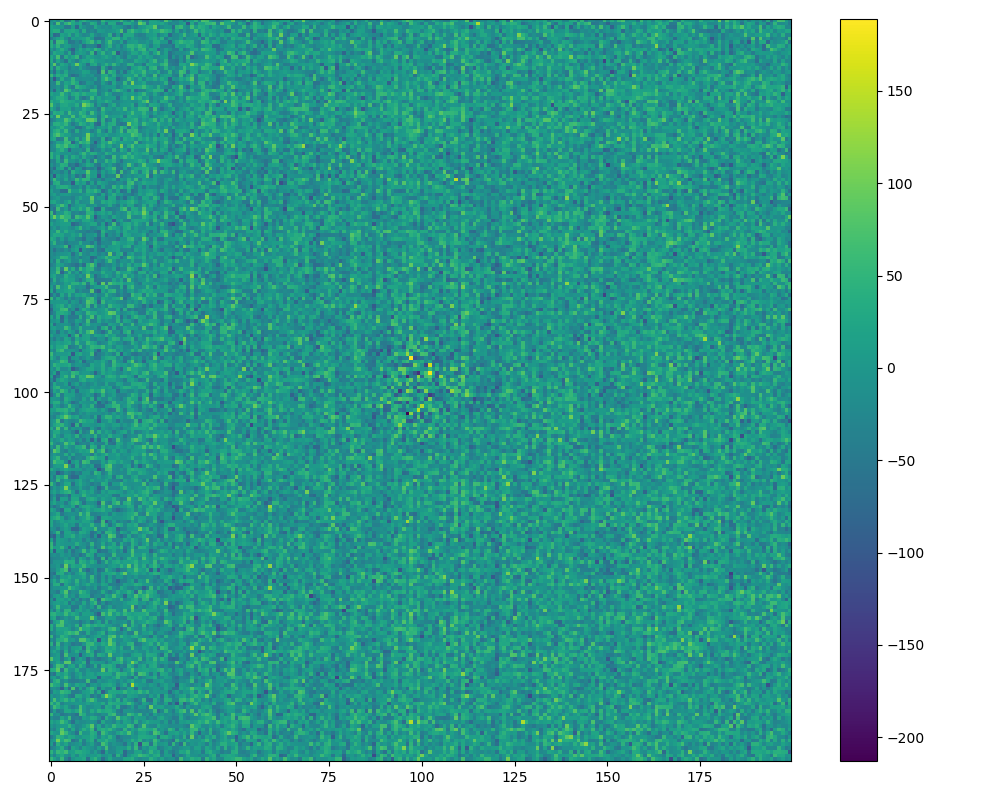

5577.437359714059

In [13]:
figure()
residual = photometry_tight.residual(result_table_tight)
imshow(residual[400:600,400:600])
colorbar()
np.max(img_tight)

<IPython.core.display.Javascript object>


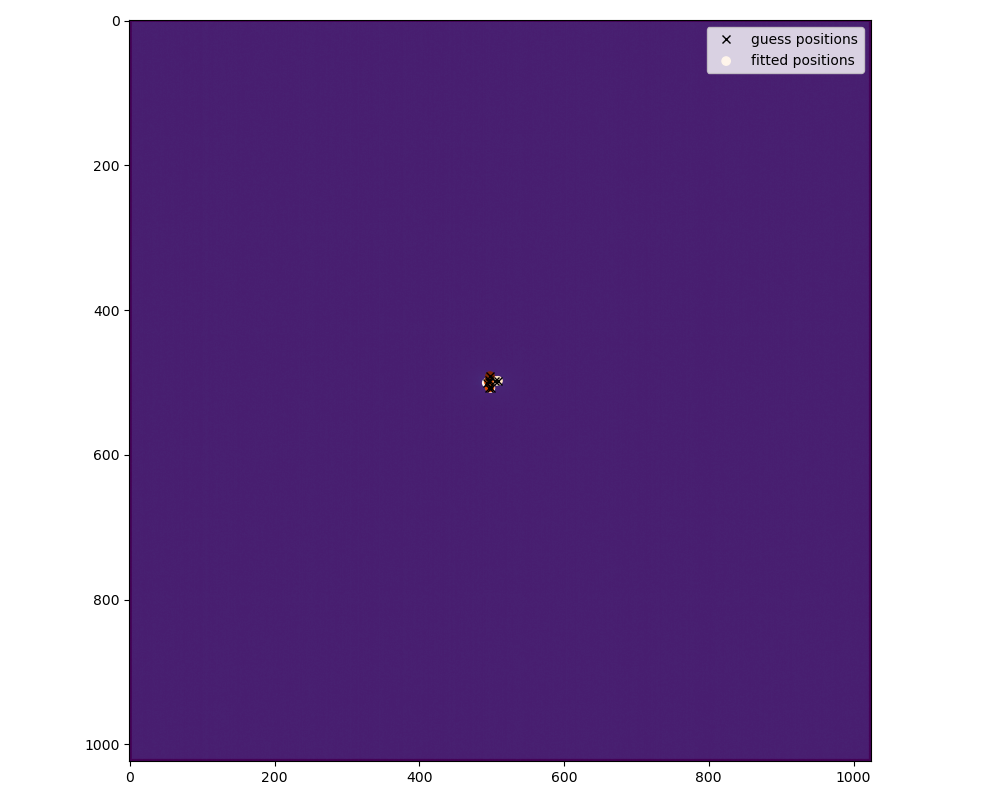

In [37]:
image_and_sources(img_tight, result_table_tight)

<IPython.core.display.Javascript object>


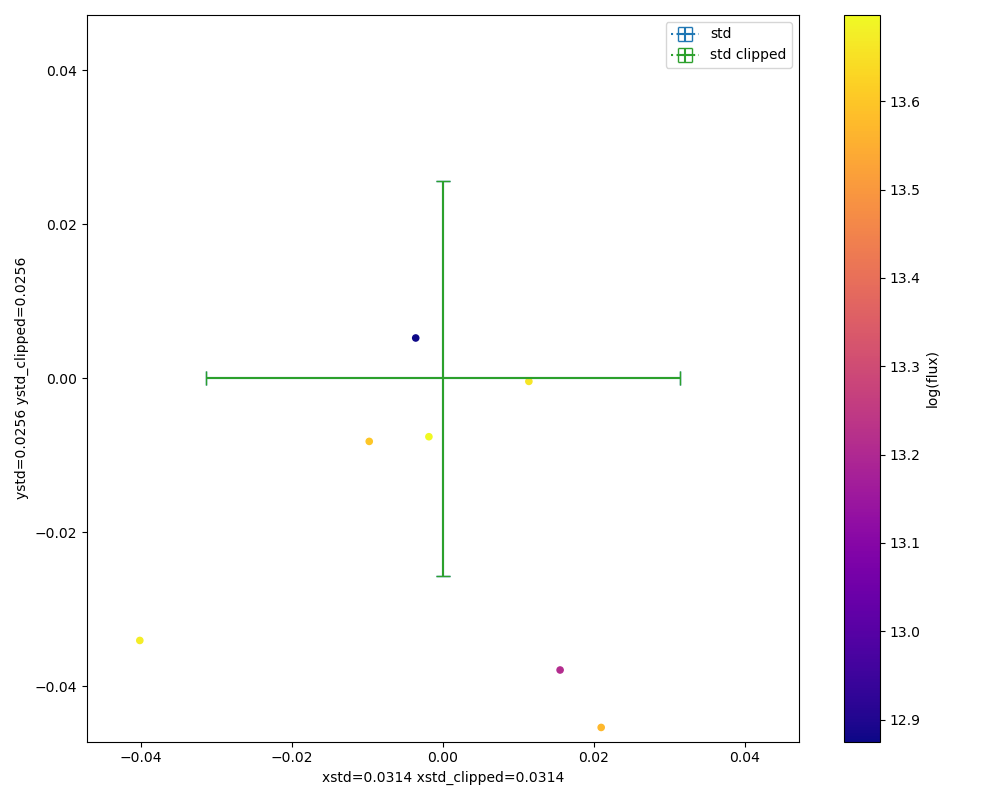

In [38]:
xy_scatter(result_table_tight)

# Isolated groups

In [54]:
rng = np.random.default_rng(seed=11)
def recipe():
    return scopesim_groups(N1d=4, border=200, group_size=8, group_radius=10, jitter=8,
                           magnitude=lambda N: rng.uniform(20.5, 21.5, size=N),
                           custom_subpixel_psf=model, seed=11)

img_isolated, table_isolated = read_or_generate_image('isolated16x8', recipe=recipe)
guess_table_isolated = prepare_table(table_isolated)

photometry_isolated = IncrementalFitPhotometry(MMMBackground(),
                                      model,
                                      max_group_size=100,
                                      group_extension_radius=20,
                                      fit_stages=fit_stages_tight)

result_table_isolated = photometry_isolated.do_photometry(img_isolated, guess_table_isolated)

Preparing 1 FieldOfViews
placing sources...


  0%|          | 0/128 [00:00<?, ?it/s]

fitting groups in stage 1/6:   0%|          | 0/16 [00:00<?, ?it/s]

fitting groups in stage 2/6:   0%|          | 0/16 [00:00<?, ?it/s]

fitting groups in stage 3/6:   0%|          | 0/16 [00:00<?, ?it/s]

fitting groups in stage 4/6:   0%|          | 0/16 [00:00<?, ?it/s]

fitting groups in stage 5/6:   0%|          | 0/16 [00:00<?, ?it/s]

fitting groups in stage 6/6:   0%|          | 0/16 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


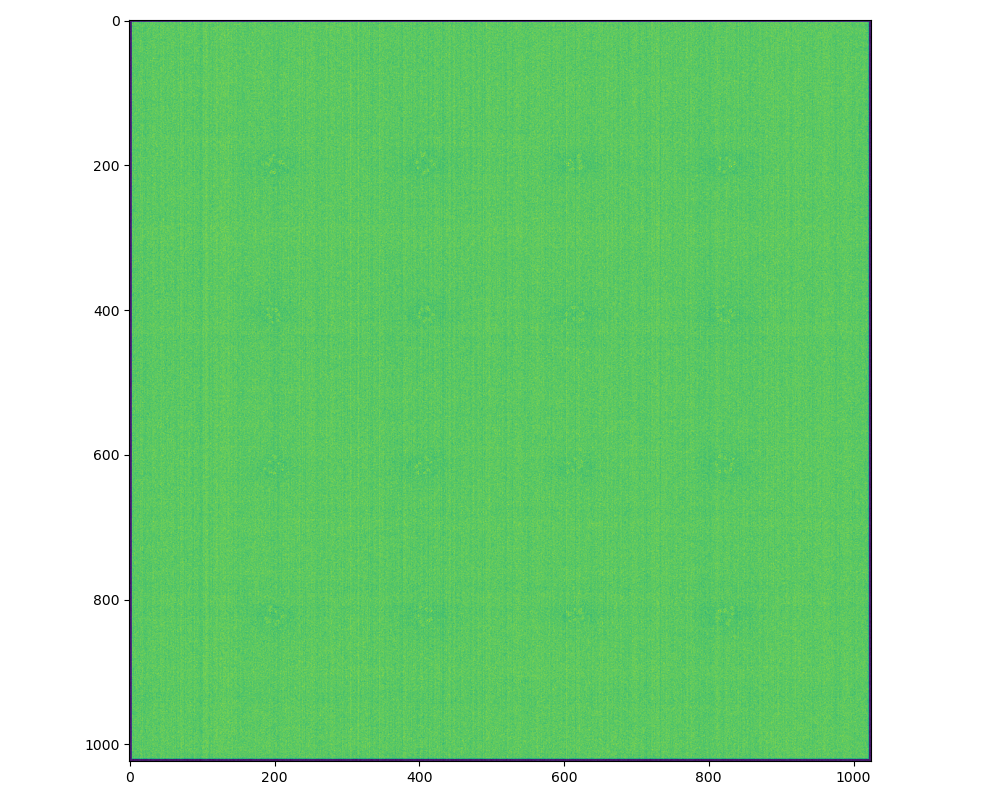

In [55]:
residual_isolated = photometry_isolated.residual(result_table_isolated)
plt.figure()
imshow(residual_isolated)

<IPython.core.display.Javascript object>


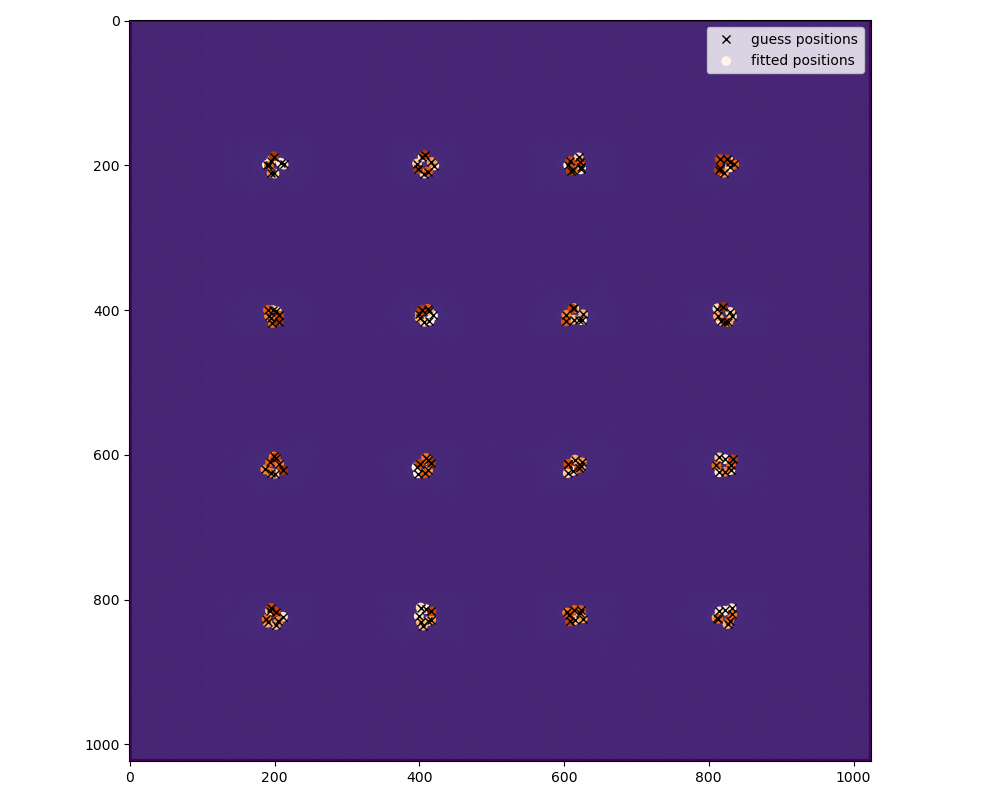

In [56]:
image_and_sources(img_isolated, result_table_isolated)

<IPython.core.display.Javascript object>


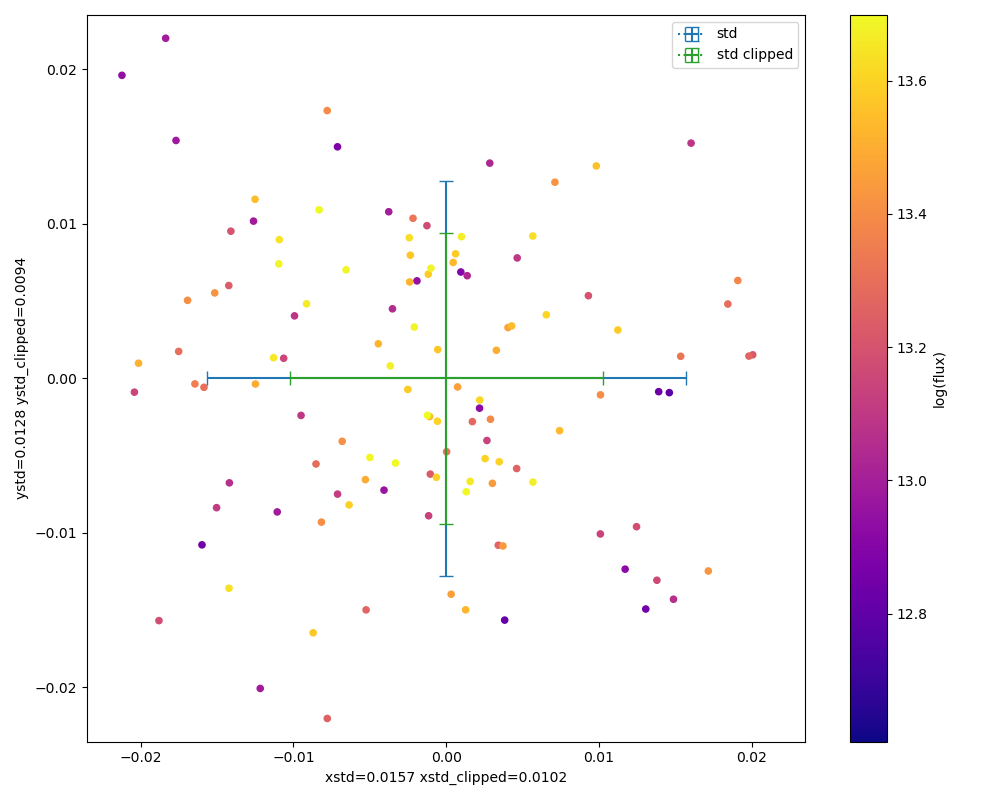

In [57]:
xy_scatter(result_table_isolated)

# small cluster

In [58]:
rng = np.random.default_rng(seed=11)
def recipe():
    return gaussian_cluster(N=100, tightness=0.3, magnitude=lambda N: rng.uniform(20.5, 21.5, size=N), custom_subpixel_psf=model, seed=11)

img_smallcluster, table_smallcluster = read_or_generate_image('clusterN100', recipe=recipe)

guess_table_smallcluster = prepare_table(table_smallcluster)

fit_stages_smallcluster = [FitStage(10, 0.001, 0.001, np.inf, all_individual), # first stage: flux is wildly off, get decent guess
              FitStage(10, 2., 2., 50_000, all_individual),
              FitStage(10, 1., 1., 20_000, brightest_simultaneous(3)),
              FitStage(10, 1., 1., 20_000, brightest_simultaneous(5)),
              FitStage(10, 0.5, 0.5, np.inf, all_simultaneous),
              FitStage(50, 0.2, 0.2, 10_000, all_simultaneous)
              ]

photometry_smallcluster = IncrementalFitPhotometry(MMMBackground(),
                                      model,
                                      max_group_size=10,
                                      group_extension_radius=30,
                                      fit_stages=fit_stages_smallcluster)

result_table_smallcluster = photometry_smallcluster.do_photometry(img_smallcluster, guess_table_smallcluster)

fitting groups in stage 1/6:   0%|          | 0/33 [00:00<?, ?it/s]

fitting groups in stage 2/6:   0%|          | 0/33 [00:00<?, ?it/s]

fitting groups in stage 3/6:   0%|          | 0/35 [00:00<?, ?it/s]

fitting groups in stage 4/6:   0%|          | 0/35 [00:00<?, ?it/s]

Process ForkPoolWorker-22:
Traceback (most recent call last):
  File "/usr/lib/python3.10/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/site-packages/multiprocess/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.10/site-packages/multiprocess/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/home/basti/Sync/ma/photutils/photutils/psf/incremental_fit_photometry.py", line 286, in fit_group
    fit_result = least_squares(objective, initial_parameters, bounds=(lbounds, ubounds))
  File "/usr/lib/python3.10/site-packages/scipy/optimize/_lsq/least_squares.py", line 928, in least_squares
    result = trf(fun_wrapped, jac_wrapped, x0, f0, J0, lb, ub, ftol, xtol,
  File "/usr/lib/python3.10/site-packages/scipy/optim

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


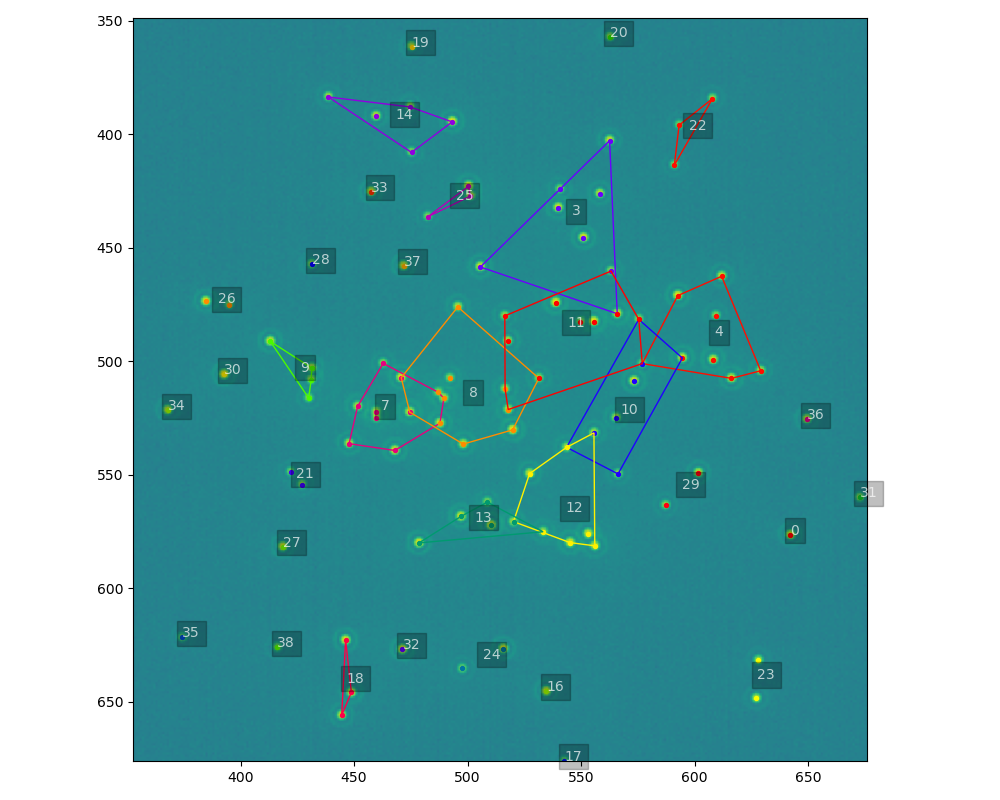

In [60]:
visualize_grouper(img_smallcluster, table_smallcluster, max_size=10, halo_radius=30)

<IPython.core.display.Javascript object>


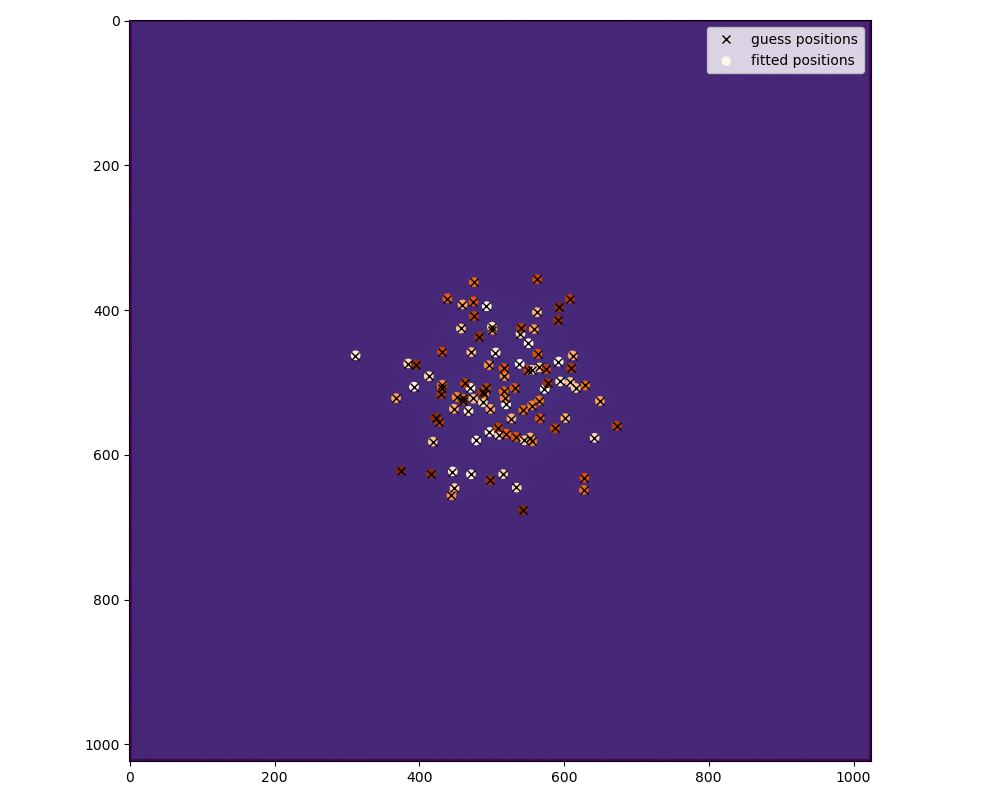

In [48]:
image_and_sources(img_smallcluster, result_table_smallcluster)

<IPython.core.display.Javascript object>


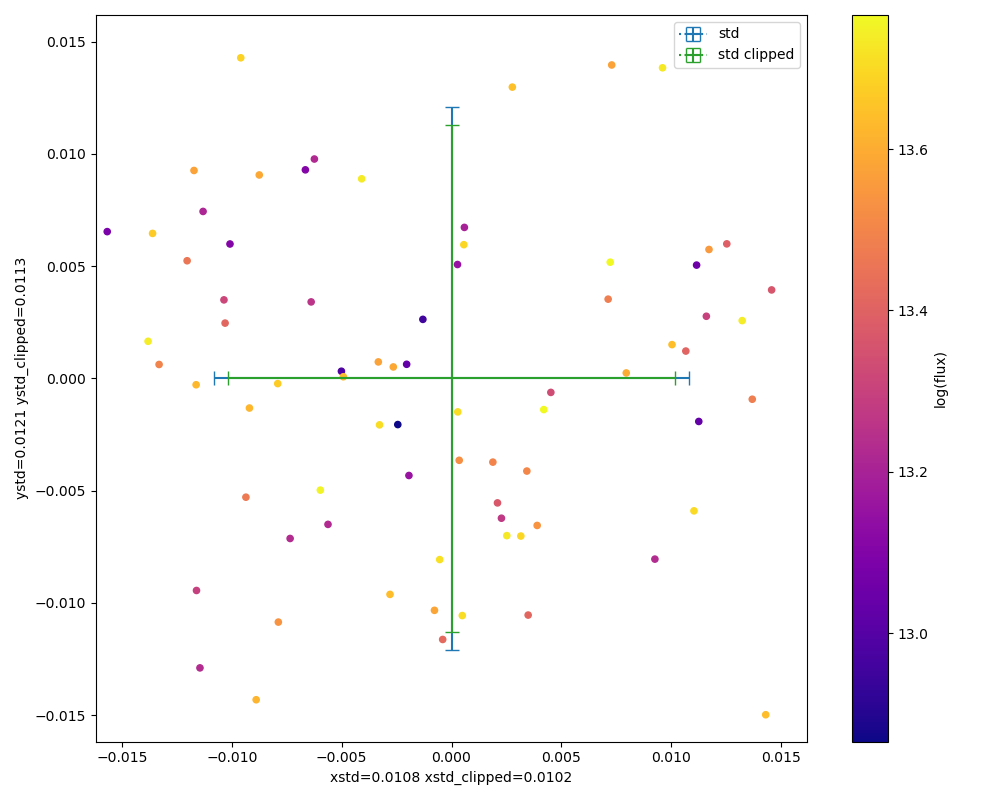

In [53]:
xy_scatter(result_table_smallcluster)

<IPython.core.display.Javascript object>


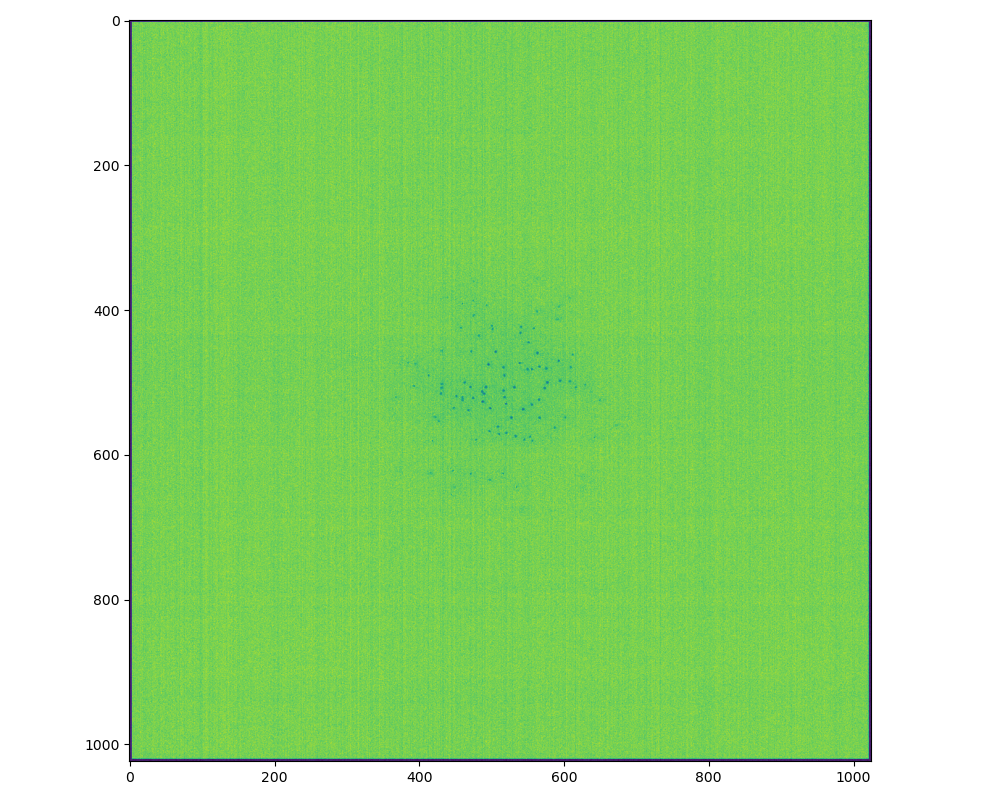

In [52]:
residual_smallcluster = photometry_smallcluster.residual(result_table_smallcluster)
plt.figure()
plt.imshow(residual_smallcluster)

# tighter cluster

In [5]:
rng = np.random.default_rng(seed=11)
def recipe():
    return gaussian_cluster(N=150, tightness=0.25, magnitude=lambda N: rng.uniform(20.5, 21.5, size=N), custom_subpixel_psf=model, seed=11)

img, table = read_or_generate_image('clusterN150', recipe=recipe)
guess_table = table.copy()

guess_table.rename_columns(['x', 'y', 'f'], [xguessname, yguessname, fluxguessname])
guess_table['x_orig'] = guess_table['x_0'].copy()
guess_table['y_orig'] = guess_table['y_0'].copy()
guess_table['x_0'] += rng.uniform(-0.5, 0.5, len(guess_table))
guess_table['y_0'] += rng.uniform(-0.5, 0.5, len(guess_table))
guess_table.sort(fluxguessname, reverse=True)

fit_stages_tight = [FitStage(10, 1e-11, 1e-11, np.inf, all_individual), # first stage: flux is wildly off, get decent guess
                    FitStage(10, 0.5, 0.5, 100, all_individual),
                    FitStage(20, 0.25, 0.25, 5000, brightest_simultaneous(5)),
                    FitStage(20, 0.25, 0.25, 2000, not_brightest_individual(5)),
                    FitStage(40, 0.1, 0.1, 1000, all_simultaneous),
              ]

photometry = IncrementalFitPhotometry(MMMBackground(),
                                      model,
                                      max_group_size=20,
                                      group_extension_radius=30,
                                      fit_stages=fit_stages_tight,
                                      use_noise=True)

result_table_weight = photometry.do_photometry(img, guess_table)

photometry_noweight = IncrementalFitPhotometry(MMMBackground(),
                                      model,
                                      max_group_size=20,
                                      group_extension_radius=30,
                                      fit_stages=fit_stages_tight,
                                      use_noise=False)

result_table_noweight = photometry_noweight.do_photometry(img, guess_table)

fitting groups in stage 1/5:   0%|          | 0/14 [00:00<?, ?it/s]

fitting groups in stage 2/5:   0%|          | 0/14 [00:00<?, ?it/s]

fitting groups in stage 3/5:   0%|          | 0/13 [00:00<?, ?it/s]

fitting groups in stage 4/5:   0%|          | 0/13 [00:00<?, ?it/s]

fitting groups in stage 5/5:   0%|          | 0/13 [00:00<?, ?it/s]

fitting groups in stage 1/5:   0%|          | 0/14 [00:00<?, ?it/s]

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


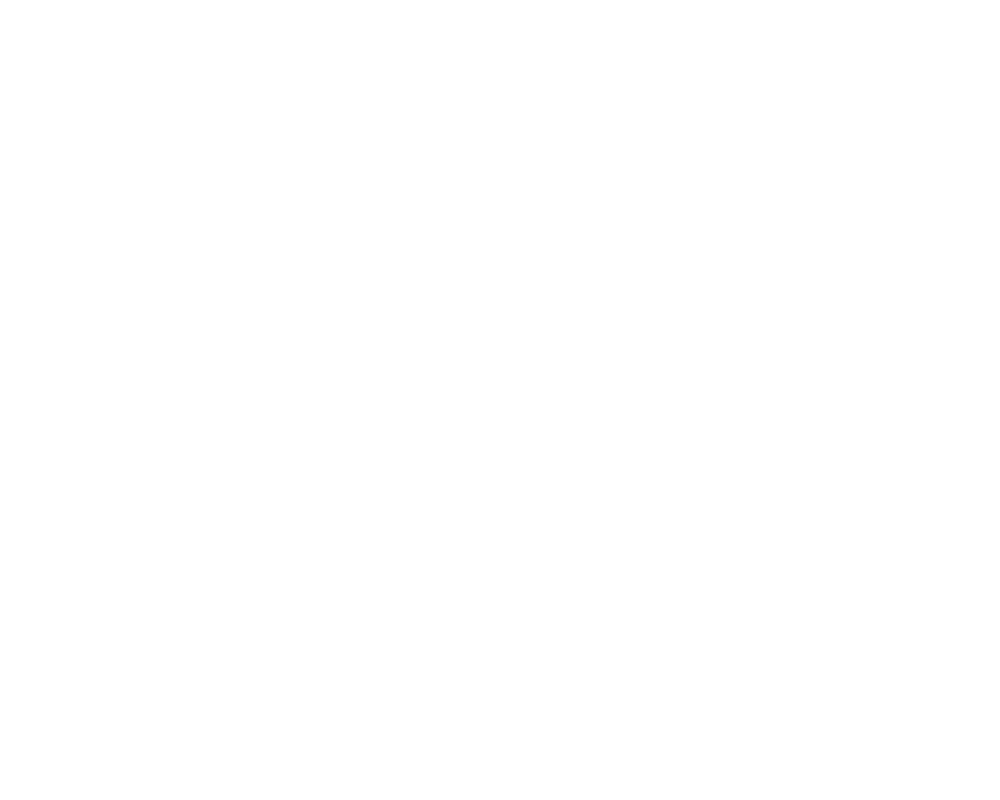

NameError: name 'guess_table' is not defined

In [6]:
plt.figure()
guess_table['x_fit'] = guess_table['x_0']
guess_table['y_fit'] = guess_table['y_0']
guess_table['update'] = True
groups = make_groups(guess_table, 10, 30)

group_ids = np.sort(np.unique([i for group in groups for i in group['group_id']]))
max_id = np.max(group_ids)

for group in groups:
    core_group = group[group['update']==True]
    group_id = core_group['group_id'][0]
    
    cmap = plt.get_cmap('prism')
    
    xy_curr = np.array((group['x_fit'], group['y_fit'])).T
    
    if len(group)>=3:
        hull = ConvexHull(xy_curr)
        vertices = xy_curr[hull.vertices]
        poly=Polygon(vertices, fill=False, color=cmap(group_id/max_id))
        plt.gca().add_patch(poly)
    
    plt.scatter(core_group['x_fit'], core_group['y_fit'], color=cmap(group_id/max_id), s=8)

    plt.annotate(group_id, (np.mean(core_group['x_fit']),np.mean(core_group['y_fit'])))
    

plt.imshow(img)
pass

In [ ]:
plt.figure()
plt.imshow(img)
plt.plot(result_table['x_0'], result_table['y_0'], 'kx')
plt.plot(result_table['x_fit'], result_table['y_fit'], 'ro')
plt.show()

In [26]:
# Default cluster

img, table = read_or_generate_image('gausscluster_N2000_mag22_subpixel')
guess_table = table.copy()

guess_table.rename_columns(['x', 'y', 'f'], [xguessname, yguessname, fluxguessname])
guess_table['x_orig'] = guess_table['x_0'].copy()
guess_table['y_orig'] = guess_table['y_0'].copy()
guess_table['x_0'] += rng.uniform(-0.5, 0.5, len(guess_table))
guess_table['y_0'] += rng.uniform(-0.5, 0.5, len(guess_table))
guess_table.sort(fluxguessname, reverse=True)

fit_stages_tight = [FitStage(10, 1e-10, 1e-10, np.inf, all_individual), # first stage: flux is wildly off, get decent guess
                    FitStage(10, 0.5, 0.5, 5000, all_individual),
                    FitStage(20, 0.5, 0.5, 10000, brightest_simultaneous(3)),
                    FitStage(20, 0.25, 0.25, 5000, brightest_simultaneous(7)),
                    FitStage(20, 0.25, 0.25, 2000, not_brightest_individual(7)),
                    FitStage(40, 0.1, 0.1, 1000, all_simultaneous),
              ]

#photometry = IncrementalFitPhotometry(MMMBackground(),
#                                      model,
#                                      max_group_size=12,
#                                      group_extension_radius=40,
#                                      fit_stages=fit_stages_tight)

#result_table_weight = photometry.do_photometry(img, guess_table)

photometry_noweight = IncrementalFitPhotometry(MMMBackground(),
                                      model,
                                      max_group_size=25,
                                      group_extension_radius=30,
                                      fit_stages=fit_stages_tight,
                                      use_noise=False)

result_table_noweight = photometry_noweight.do_photometry(img, guess_table)

fitting groups in stage 1/6:   0%|          | 0/296 [00:00<?, ?it/s]

fitting groups in stage 2/6:   0%|          | 0/296 [00:00<?, ?it/s]

fitting groups in stage 3/6:   0%|          | 0/307 [00:00<?, ?it/s]

fitting groups in stage 4/6:   0%|          | 0/307 [00:00<?, ?it/s]

fitting groups in stage 5/6:   0%|          | 0/300 [00:00<?, ?it/s]

fitting groups in stage 6/6:   0%|          | 0/301 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


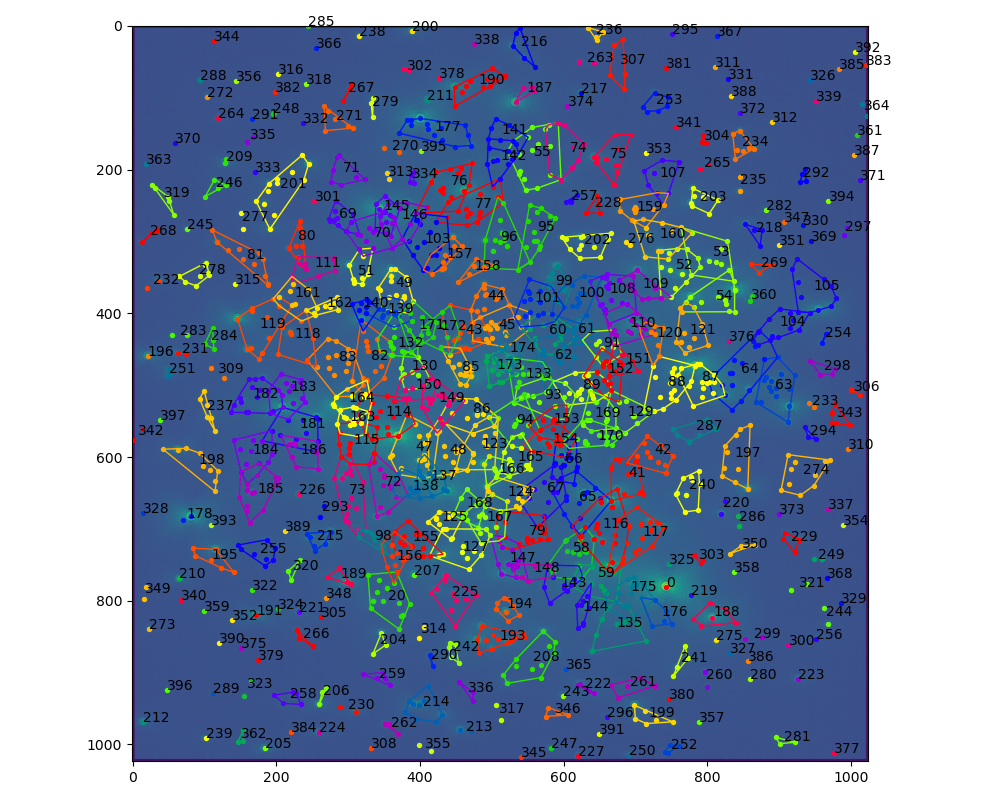

In [17]:
plt.figure()
guess_table['x_fit'] = guess_table['x_0']
guess_table['y_fit'] = guess_table['y_0']
guess_table['update'] = True
groups = make_groups(guess_table, 15, 20)

group_ids = np.sort(np.unique([i for group in groups for i in group['group_id']]))
max_id = np.max(group_ids)

for group in groups:
    core_group = group[group['update']==True]
    group_id = core_group['group_id'][0]
    
    cmap = plt.get_cmap('prism')
    
    xy_curr = np.array((group['x_fit'], group['y_fit'])).T
    
    if len(group)>=3:
        hull = ConvexHull(xy_curr)
        vertices = xy_curr[hull.vertices]
        poly=Polygon(vertices, fill=False, color=cmap(group_id/max_id))
        plt.gca().add_patch(poly)
    
    plt.scatter(core_group['x_fit'], core_group['y_fit'], color=cmap(group_id/max_id), s=8)

    plt.annotate(group_id, (np.mean(core_group['x_fit']),np.mean(core_group['y_fit'])))
    

plt.imshow(img, norm=LogNorm())
pass

In [ ]:
plt.figure()
plt.imshow(img, norm=LogNorm())
plt.plot(result_table['x_0'], result_table['y_0'], 'kx')
plt.plot(result_table['x_fit'], result_table['y_fit'], 'ro', ms=3)
plt.show()

In [ ]:
def do_scatter(result_table):
    plt.figure()
    result_table.sort('flux_fit', reverse=False)

    xdiff, ydiff = result_table['x_fit']-result_table['x_orig'], result_table['y_fit']-result_table['y_orig']
    xstd, xstd_clipped = np.std(xdiff),sigma_clipped_stats(xdiff, sigma=3)[2]
    ystd, ystd_clipped = np.std(ydiff),sigma_clipped_stats(ydiff, sigma=3)[2]

    plt.scatter(xdiff,ydiff,
                c=np.log(result_table['flux_fit']), cmap='plasma', s=20)
    plt.errorbar([0],[0],xerr=xstd,yerr=ystd, capsize=5, ls=':', color='tab:blue', label='std')
    plt.errorbar([0],[0],xerr=xstd_clipped,yerr=ystd_clipped, capsize=5, ls=':', color='tab:green', label='std clipped')
    plt.xlabel(f'{xstd=:.4f} {xstd_clipped=:.4f}')
    plt.ylabel(f'{ystd=:.4f} {ystd_clipped=:.4f}')

    plt.xlim(-1.5*xstd,1.5*xstd)
    plt.ylim(-1.5*xstd,1.5*xstd)

    plt.colorbar(label='log(flux)')
    plt.legend()

do_scatter(result_table_noweight)
do_scatter(result_table_weight)

<IPython.core.display.Javascript object>


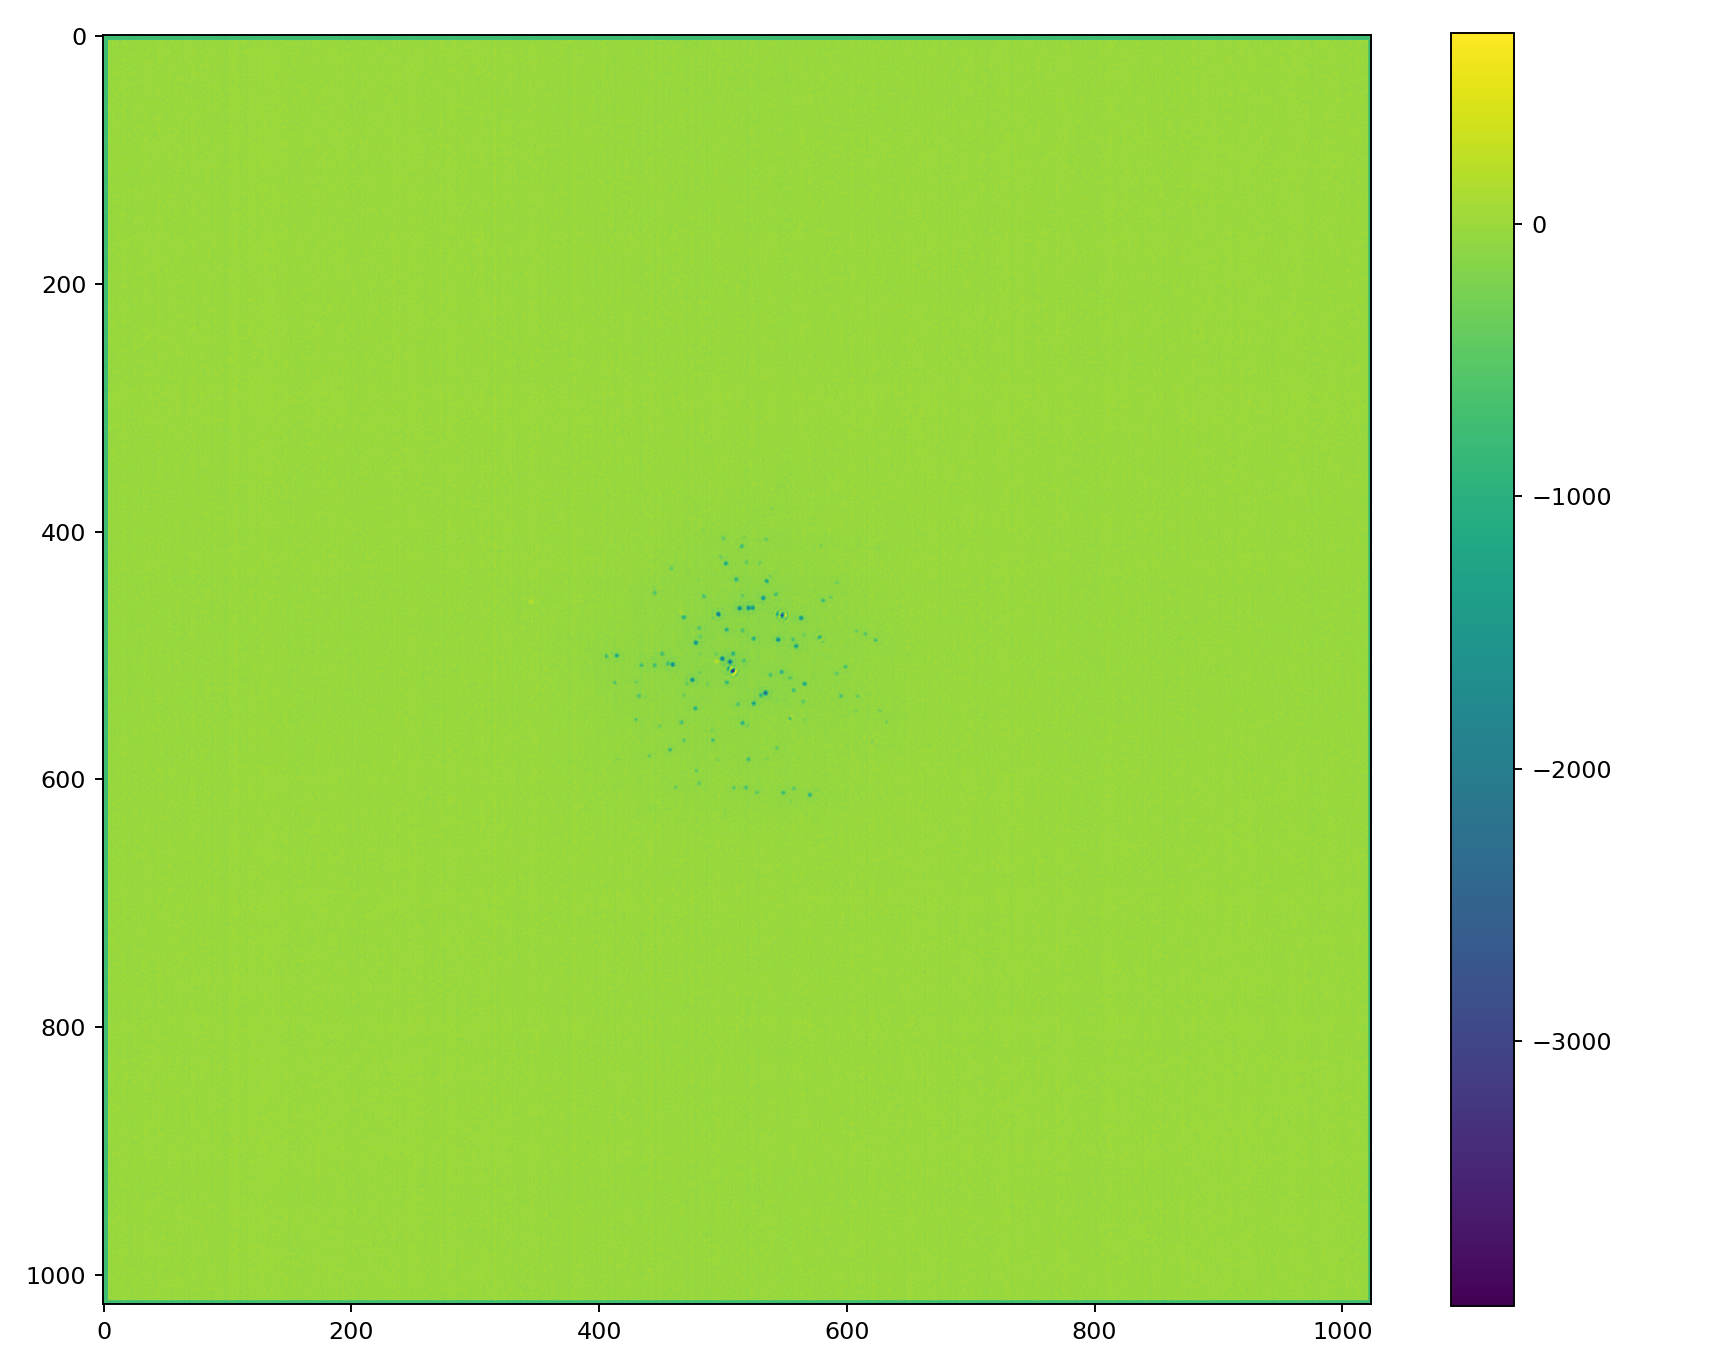

-25239760.107687667

In [8]:
#todo oversubtracting all sources, total of residual is negative...
figure()
residual = photometry.residual(result_table_weight)
imshow(residual)
colorbar()
np.max(img)
np.sum(residual)

In [12]:
np.sum(residual-np.mean(residual))

-2.7939677238464355e-09

<IPython.core.display.Javascript object>


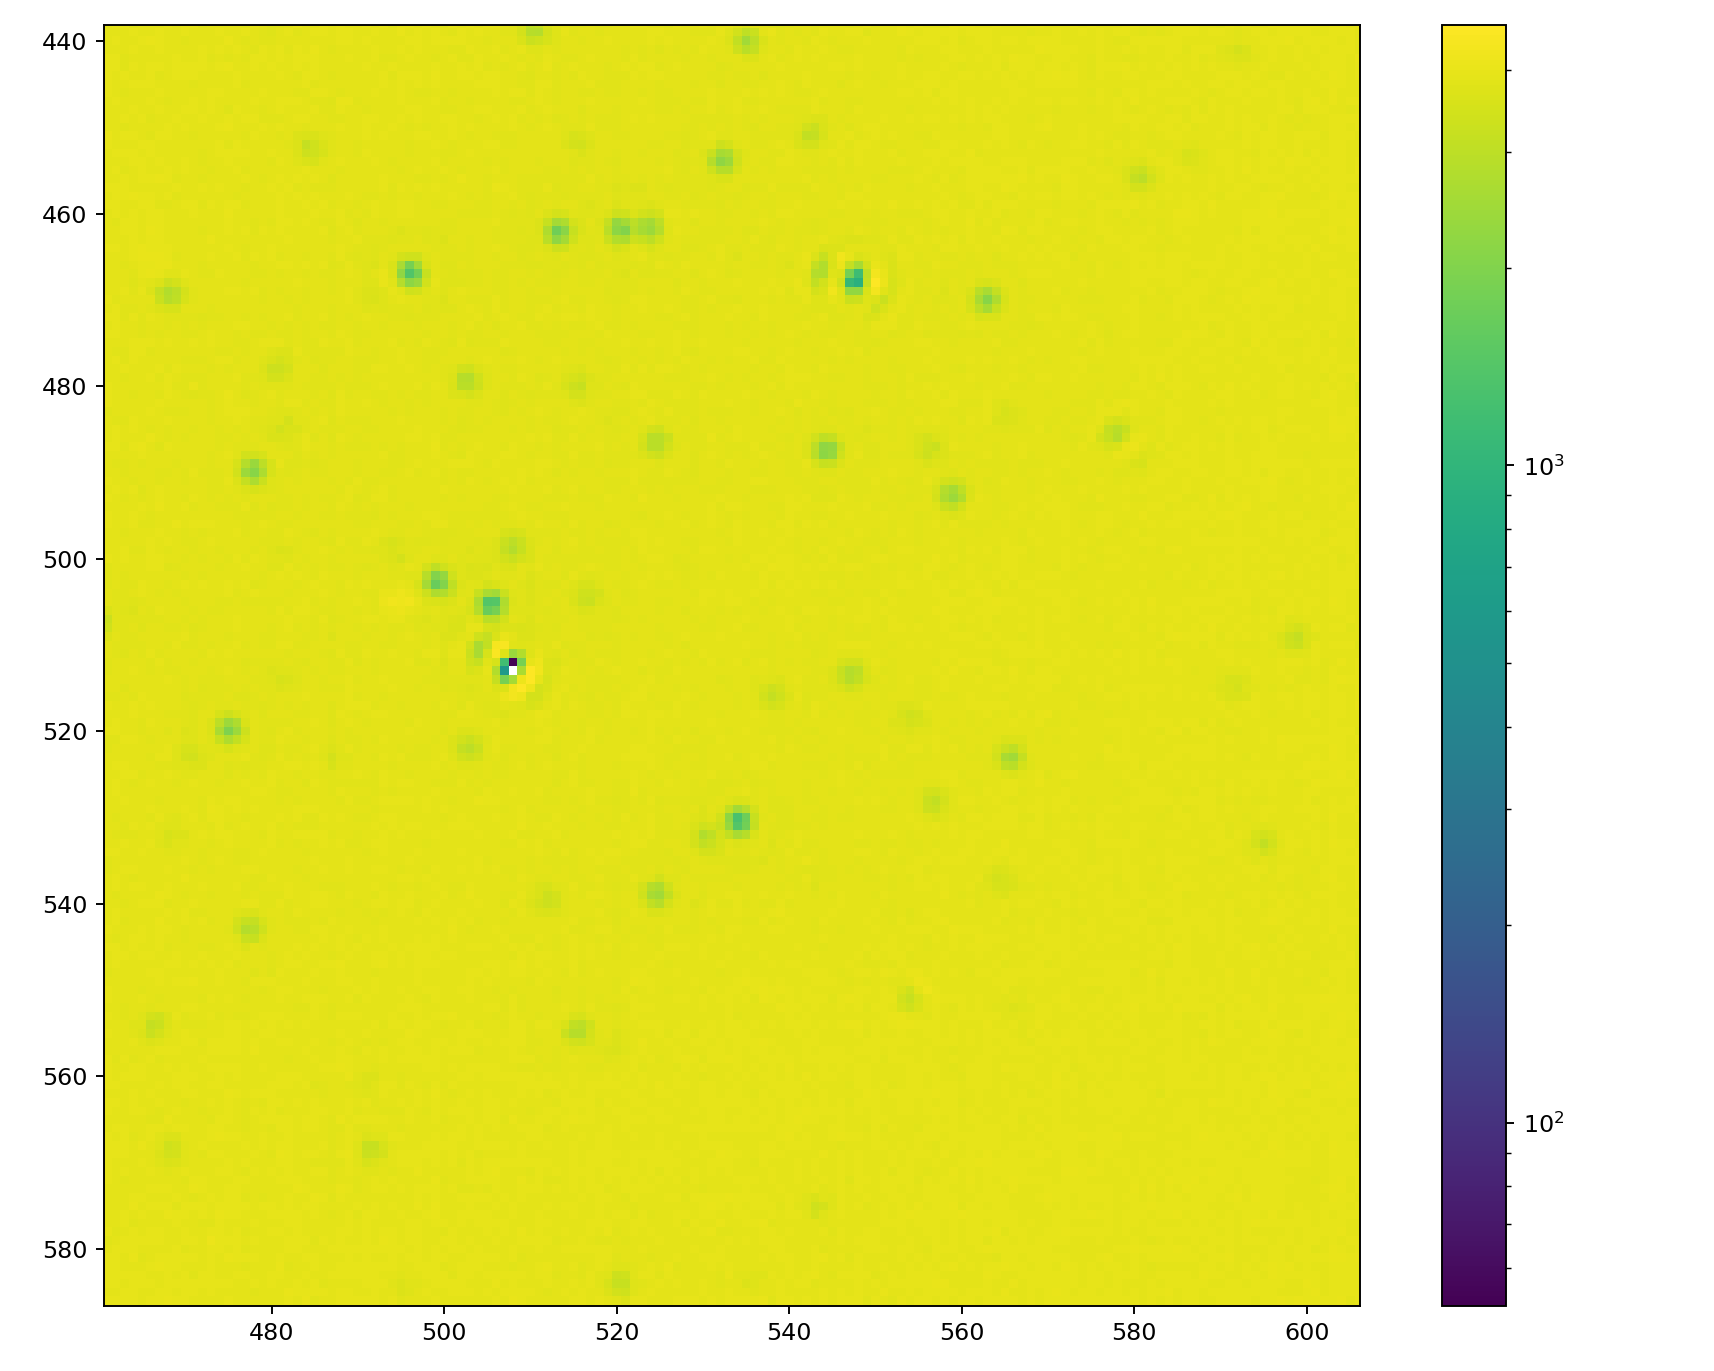

In [15]:
figure()
imshow(residual-np.min(residual), norm=LogNorm())
colorbar()

In [ ]:
result_table_weight.sort('id')
result_table_noweight.sort('id')

plt.figure()
plt.scatter(result_table_weight['x_fit'] - result_table_noweight['x_fit'],
            result_table_weight['y_fit'] - result_table_noweight['y_fit'])

In [ ]:
result_table_noweight

In [ ]:
# just for creating a stupid picture
plt.figure()

def do_plotting(groups):
    group_ids = np.sort(np.unique([i for group in groups for i in group['group_id']]))
    max_id = np.max(group_ids)

    for group in groups:
        group['x_fit'] += np.random.uniform(-0.3,0.3, len(group))
        group['y_fit'] += np.random.uniform(-0.3,0.3, len(group))
        core_group = group[group['update']==True]
        group_id = core_group['group_id'][0]

        cmap = plt.get_cmap('prism')

        xy_curr = np.array((group['x_fit'], group['y_fit'])).T

        if len(group)>=3:
            hull = ConvexHull(xy_curr)
            vertices = xy_curr[hull.vertices]
            poly=Polygon(vertices, fill=False, color=cmap(group_id/max_id),alpha=0.8)
            plt.gca().add_patch(poly)

        plt.scatter(core_group['x_fit'], core_group['y_fit'], color=cmap(group_id/max_id), s=8, alpha=0.2)

groups = make_groups(result_table, 8, 10)
do_plotting(groups)
groups = make_groups(result_table, 12, 40)
do_plotting(groups)
groups = make_groups(result_table, 21, 40)
do_plotting(groups)
groups = make_groups(result_table, 51, 30)
do_plotting(groups)
groups = make_groups(result_table, 100, 80)
do_plotting(groups)
groups = make_groups(result_table, 200, 80)
do_plotting(groups)

plt.imshow(img, norm=LogNorm())

save_plot('.', 'totally_valid_plot')
pass